In [929]:
#install some necessary libraries
!pip install pandas sklearn xgboost

In [1]:
# import the libraries we'll need
import pandas as pd
import seaborn as sns
import numpy as np
import json
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, HashingVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV
from collections import Counter
import matplotlib.pyplot as plt

In [2]:
# Set pandas to show all columns when you print a dataframe
pd.set_option('display.max_columns', None)

# Global setting here you choose the dataset number and classification type for the model
dataset_number = 4 # Options are [1, 2, 3, 4]
test_type = 'attack_type' # Options are ['label', 'attack_type']

# Read the json and read it to a pandas dataframe object, you can change these settings
with open(f'datasets/dataset_{str(dataset_number)}_train.json') as file:
    raw_ds = json.load(file)
df = pd.json_normalize(raw_ds, max_level=2)

# Shoe the first five lines of the dataframe to see if everything was read accordingly 
df.head()

,request.headers.Host,request.headers.User-Agent,request.headers.Accept-Encoding,request.headers.Accept,request.headers.Connection,request.headers.Sec-Ch-Ua-Platform,request.headers.Sec-Ch-Ua-Mobile,request.headers.Accept-Language,request.headers.Sec-Fetch-Site,request.headers.Sec-Fetch-Mode,request.headers.Cache-Control,request.headers.Sec-Fetch-User,request.headers.Sec-Fetch-Dest,request.headers.Set-Cookie,request.headers.Date,request.method,request.url,request.body,response.status,response.headers.Content-Type,response.headers.Content-Length,response.status_code,response.body,request.Attack_Tag,response.headers.Location,request.headers.Cookie,request.headers.Content-Length,response.headers.Set-Cookie,request.headers.Upgrade-Insecure-Requests
0,127.0.0.1:5000,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10_1...,"gzip, deflate, br",*/*,keep-alive,"""Windows""",?0,de-CH,none,same-origin,no-store,?1,document,['ttauth=AnmLHb1kdzYvpficmoZ6ahuxln7RK43GPlS6Q...,"Sun, 18 Dec 2022 01:42:25 GMT",GET,http://127.0.0.1:5000/orders/get/random/2,,200 OK,application/json,8,200,"[{}, {}]",NaN,NaN,NaN,NaN,NaN,NaN
1,127.0.0.1:5000,Mozilla/5.0 (Windows NT 6.3; Win64; x64) Apple...,"gzip, deflate, br",*/*,keep-alive,"""Windows""",?0,"en-US,en;q=0.9,he;q=0.8",none,websocket,no-cache,?1,document,['cid=9ML55TwNFFw14MA2N-N6B8v_LTjMEyppvz3F-H99...,"Sun, 18 Dec 2022 01:44:11 GMT",GET,http://127.0.0.1:5000/orders/check/exists?val=...,,404 NOT FOUND,application/json,31,404,"{""error"": ""Order ID not found""}",NaN,NaN,NaN,NaN,NaN,NaN
2,127.0.0.1:5000,Mozilla/5.0 (Windows NT 5.1; rv:31.0) Gecko/20...,"gzip, deflate, br${jndi:ldaphabbologinbr.rel7....",*/*,keep-alive,NaN,?1,"en-US,en;q=0.9,he;q=0.8",none,same-origin,no-store,?1,document,['ttauth=XSgpzlTZBc47Xm36ObpZplFzV2KbUgC68xBcA...,"Sun, 18 Dec 2022 01:34:30 GMT",GET,http://127.0.0.1:5000/login/user?username=Rich...,,401 UNAUTHORIZED,application/json,26,401,"{""error"": ""Access denied""}",LOG4J,NaN,NaN,NaN,NaN,NaN
3,127.0.0.1:5000,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10; ...,"x-gzip, x-deflate, gzip, deflate",*/*,keep-alive,"""Windows""",?1,"en-US,en;q=0.9,he;q=0.8",none,websocket,no-cache,?1,document,['ttauth=kOqLuuI_RaiyuKw-926q36BZ4s3ZH251NQ37i...,"Sun, 18 Dec 2022 01:43:59 GMT",GET,http://127.0.0.1:5000/greet/Warren,,200 OK,text/html; charset=utf-8,22,200,text/html; charset=utf-8,NaN,NaN,NaN,NaN,NaN,NaN
4,127.0.0.1:5000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,"gzip, deflate, br",*/*,keep-alive,"""Windows""",?1,de-CH,none,websocket,max-age=0,?1,document,['ttauth=rN-ka7ksV-2K6QtY-_wNmdI1i4zY2kVoDQW6e...,"Sun, 18 Dec 2022 01:23:50 GMT",GET,http://127.0.0.1:5000/states/Bagdon?resource=R...,,404 NOT FOUND,application/json,28,404,"{""error"": ""State not found""}",NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
def check_for_Log4j(row):
    """
    NDI stands for Java Naming and Directory Interface. 
    It is a Java API that allows Java programs to access naming and directory services, such as LDAP and DNS.
    In the context of Log4j, JNDI can be used to obtain a reference to a Log4j configuration file stored in a directory service.
    This can be malicious if an attacker is able to modify the configuration file to cause Log4j to 
    log sensitive information or to execute arbitrary code. 
    """
    if row.str.contains('jndi:').any():
        return 1
    else:
        return 0

df['Log4j'] = df.apply(lambda row: check_for_Log4j(row), axis=1)

In [4]:
def check_for_SQL_injection(row):
    """
    %20or%20" is the equivalent of " or ".
    This can be used in a SQL injection attack by appending it to the end of a query 
    in order to comment out the rest of the query and execute arbitrary SQL commands.
    """
    if 'SELECT' in row["request.url"] or '%20or%20' in row["request.url"]:
        return 1
    else:
        return 0

df['SQL'] = df.apply(lambda row: check_for_SQL_injection(row), axis=1)

In [5]:
def check_for_RCE(row):
    """
    __globals__ attribute refers to a dictionary containing the global variables defined in the current namespace.
    can allow code to access and manipulate global variables in unintended ways.
    __builtins__ attribute refers to a dictionary containing the built-in functions and variables defined in Python.
    can allow code to access and manipulate built-in functions in unintended ways
    %3C/script%3E is a URL-encoded string that represents the characters </script>.
    __import__ attributes to import the os module and execute the system function.
    """
    if '__globals__' in row['request.url']\
        or "%3C/script%3E" in row['request.url']\
            or "__import__('os')" in row['request.url']\
                or '__builtins__' in row['request.url']:
        return 1
    else:
        return 0

df['RCE'] = df.apply(lambda row: check_for_RCE(row), axis=1)

In [6]:
def check_for_Directory_Traversal(row):
    """
    An attacker tries to access sensitive files or a restricted directory on the server.
    "../../../" is a sequence of relative path traversal operators that can be used to 
    navigate up multiple levels in a file system directory tree.
    This can be used to access files or directories that are outside the intended directory structure, 
    potentially leading to sensitive information disclosure or unauthorized access.
    """
    if '../secrets.txt' in row["request.url"]\
            or '../etc/passwd.txt' in row["request.url"]\
                or ('../../../' in row["request.url"] and ('error' in row["response.body"])):
        return 1
    else:
        return 0

df['Directory_Traversal'] = df.apply(lambda row: check_for_Directory_Traversal(row), axis=1)

In [7]:
def check_for_Cookie_injection(row):
    if 'cookielogin' in row["request.url"]:
        return 1
    else:
        return 0

df['Cookie_Injection'] = df.apply(lambda row: check_for_Cookie_injection(row), axis=1)

In [8]:
def check_for_Log_Forge(row):
    if '%20user%20' in row["request.url"]:
        return 1
    else:
        return 0

df['Log_Forge'] = df.apply(lambda row: check_for_Log_Forge(row), axis=1)

In [9]:
def check_for_XSS(row):
    if ('script' in row["request.url"] and 'http://127.0.0.1:5000/forum?message=' in row["request.url"]) or row["request.url"] == 'http://127.0.0.1:5000/forum':
        return 1
    else:
        return 0

df['XSS'] = df.apply(lambda row: check_for_XSS(row), axis=1)

In [10]:
# Fill the black attack tag lines with "Benign" string
df['request.Attack_Tag'] = df['request.Attack_Tag'].fillna('Benign')
df['attack_type'] = df['request.Attack_Tag']
df.drop('request.Attack_Tag', axis=1, inplace=True)

In [11]:
# Remove all NAN columns or replace with desired string
# This loop iterates over all of the column names which are all NaN
for column in df.columns[df.isna().any()].tolist():
    # df.drop(column, axis=1, inplace=True)
    df[column] = df[column].fillna('None')
    
# If you want to detect columns that may have only some NaN values use this:
# df.loc[:, df.isna().any()].tolist()

df.head()

,request.headers.Host,request.headers.User-Agent,request.headers.Accept-Encoding,request.headers.Accept,request.headers.Connection,request.headers.Sec-Ch-Ua-Platform,request.headers.Sec-Ch-Ua-Mobile,request.headers.Accept-Language,request.headers.Sec-Fetch-Site,request.headers.Sec-Fetch-Mode,request.headers.Cache-Control,request.headers.Sec-Fetch-User,request.headers.Sec-Fetch-Dest,request.headers.Set-Cookie,request.headers.Date,request.method,request.url,request.body,response.status,response.headers.Content-Type,response.headers.Content-Length,response.status_code,response.body,response.headers.Location,request.headers.Cookie,request.headers.Content-Length,response.headers.Set-Cookie,request.headers.Upgrade-Insecure-Requests,Log4j,SQL,RCE,Directory_Traversal,Cookie_Injection,Log_Forge,XSS,attack_type
0,127.0.0.1:5000,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10_1...,"gzip, deflate, br",*/*,keep-alive,"""Windows""",?0,de-CH,none,same-origin,no-store,?1,document,['ttauth=AnmLHb1kdzYvpficmoZ6ahuxln7RK43GPlS6Q...,"Sun, 18 Dec 2022 01:42:25 GMT",GET,http://127.0.0.1:5000/orders/get/random/2,,200 OK,application/json,8,200,"[{}, {}]",None,None,None,None,None,0,0,0,0,0,0,0,Benign
1,127.0.0.1:5000,Mozilla/5.0 (Windows NT 6.3; Win64; x64) Apple...,"gzip, deflate, br",*/*,keep-alive,"""Windows""",?0,"en-US,en;q=0.9,he;q=0.8",none,websocket,no-cache,?1,document,['cid=9ML55TwNFFw14MA2N-N6B8v_LTjMEyppvz3F-H99...,"Sun, 18 Dec 2022 01:44:11 GMT",GET,http://127.0.0.1:5000/orders/check/exists?val=...,,404 NOT FOUND,application/json,31,404,"{""error"": ""Order ID not found""}",None,None,None,None,None,0,0,0,0,0,0,0,Benign
2,127.0.0.1:5000,Mozilla/5.0 (Windows NT 5.1; rv:31.0) Gecko/20...,"gzip, deflate, br${jndi:ldaphabbologinbr.rel7....",*/*,keep-alive,None,?1,"en-US,en;q=0.9,he;q=0.8",none,same-origin,no-store,?1,document,['ttauth=XSgpzlTZBc47Xm36ObpZplFzV2KbUgC68xBcA...,"Sun, 18 Dec 2022 01:34:30 GMT",GET,http://127.0.0.1:5000/login/user?username=Rich...,,401 UNAUTHORIZED,application/json,26,401,"{""error"": ""Access denied""}",None,None,None,None,None,1,0,0,0,0,0,0,LOG4J
3,127.0.0.1:5000,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10; ...,"x-gzip, x-deflate, gzip, deflate",*/*,keep-alive,"""Windows""",?1,"en-US,en;q=0.9,he;q=0.8",none,websocket,no-cache,?1,document,['ttauth=kOqLuuI_RaiyuKw-926q36BZ4s3ZH251NQ37i...,"Sun, 18 Dec 2022 01:43:59 GMT",GET,http://127.0.0.1:5000/greet/Warren,,200 OK,text/html; charset=utf-8,22,200,text/html; charset=utf-8,None,None,None,None,None,0,0,0,0,0,0,0,Benign
4,127.0.0.1:5000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,"gzip, deflate, br",*/*,keep-alive,"""Windows""",?1,de-CH,none,websocket,max-age=0,?1,document,['ttauth=rN-ka7ksV-2K6QtY-_wNmdI1i4zY2kVoDQW6e...,"Sun, 18 Dec 2022 01:23:50 GMT",GET,http://127.0.0.1:5000/states/Bagdon?resource=R...,,404 NOT FOUND,application/json,28,404,"{""error"": ""State not found""}",None,None,None,None,None,0,0,0,0,0,0,0,Benign


In [12]:
df[(df['attack_type'] != 'LOG4J') & (df['Log4j'] == 1)]

,request.headers.Host,request.headers.User-Agent,request.headers.Accept-Encoding,request.headers.Accept,request.headers.Connection,request.headers.Sec-Ch-Ua-Platform,request.headers.Sec-Ch-Ua-Mobile,request.headers.Accept-Language,request.headers.Sec-Fetch-Site,request.headers.Sec-Fetch-Mode,request.headers.Cache-Control,request.headers.Sec-Fetch-User,request.headers.Sec-Fetch-Dest,request.headers.Set-Cookie,request.headers.Date,request.method,request.url,request.body,response.status,response.headers.Content-Type,response.headers.Content-Length,response.status_code,response.body,response.headers.Location,request.headers.Cookie,request.headers.Content-Length,response.headers.Set-Cookie,request.headers.Upgrade-Insecure-Requests,Log4j,SQL,RCE,Directory_Traversal,Cookie_Injection,Log_Forge,XSS,attack_type
1693,127.0.0.1:5000,Mozilla/5.0 (Windows NT 6.3; Win64; x64) Apple...,"gzip, deflate, br${jndi:ldapmininova.biz/downl...",*/*,keep-alive,None,?1,de,none,same-origin,max-age=0,?1,document,['cid=5JB-xAkl5qYOY7SlkQ7wdiSxhoWalHQl0rx5lcNf...,"Sun, 18 Dec 2022 01:39:01 GMT",GET,http://127.0.0.1:5000/cookielogin,,200 OK,text/html; charset=utf-8,71,200,text/html; charset=utf-8,None,None,None,None,None,1,0,0,0,1,0,0,Cookie Injection
2010,127.0.0.1:5000,Mozilla/5.0 (Windows NT 6.3; WOW64) AppleWebKi...,"gzip, deflate, br",*/*,keep-alive,"""Windows""",?0,"en-US,en;q=0.9,he;q=0.8",none,websocket,no-cache,?1,document,['cid=qRX8aU0Dq-WJ6bd_m6dGSnIn3XMU4nbykB3WplAR...,"Sun, 18 Dec 2022 01:34:12 GMT",GET,http://127.0.0.1:5000/forum?message=%3C%2Fp%3E...,,302 FOUND,text/html; charset=utf-8,199,302,text/html; charset=utf-8,/forum,None,None,None,None,1,0,0,0,0,0,1,XSS
3331,127.0.0.1:5000,Mozilla/5.0 (Windows NT 6.1; rv:27.3) Gecko/20...,"gzip, deflate, br",*/*,keep-alive,"""Windows""",?0,"en-US,en;q=0.5",none,websocket,no-store,?1,document,['cid=gaEqvX5bPC9jLYSiOSgy6gGE4l3uYkLxczeehM_d...,"Sun, 18 Dec 2022 01:32:19 GMT",GET,http://127.0.0.1:5000/orders/get/country?count...,,200 OK,application/json,155,200,"[{}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {...",None,None,None,None,None,1,1,0,0,0,0,0,SQL Injection
3452,127.0.0.1:5000,Mozilla/5.0 (Windows NT 10.0) AppleWebKit/537....,"gzip, deflate, br",*/*,keep-alive,None,?1,de-CH,none,same-origin,no-store,?1,document${jndi:ldaphttp://219.157.29.127:51608...,['ck=4-fiSC2rL-5ud5uGFpGhNQ3doxtWFBgEz4OY1FHGX...,"Sun, 18 Dec 2022 01:34:09 GMT",GET,http://127.0.0.1:5000/static/download_txt/../....,,200 OK,application/json,60,200,"{""error"": ""File ../../../../../../etc/passwd.t...",None,None,None,None,1,1,0,0,1,0,0,0,Directory Traversal
3960,127.0.0.1:5000,Mozilla/5.0 (X11; OpenBSD i386) AppleWebKit/53...,"gzip, deflate, br${jndi:ldapfacebook.com/cecil...",*/*,keep-alive,None,?0,de-CH,none,same-origin,no-store,?1,document,['ttauth=yOBlYe1eU9r2MDKmwzr5EUx6VJMKigGVOuVsI...,"Sun, 18 Dec 2022 01:25:56 GMT",GET,http://127.0.0.1:5000/login/user?username=Jone...,,401 UNAUTHORIZED,application/json,26,401,"{""error"": ""Access denied""}",None,None,None,None,None,1,1,0,0,0,0,0,SQL Injection
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
178566,127.0.0.1:5000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:29.0) G...,"gzip, deflate, br${jndi:ldapmanta.com/c/mtwckc...",*/*,keep-alive,None,?1,de,none,websocket,no-store,?1,document,['cid=CLi5GyPF269vXGJ-ML57KcUCdaRZO8DXnyPWpXtY...,"Sun, 18 Dec 2022 01:21:21 GMT",GET,http://127.0.0.1:5000/forum,,200 OK,text/html; charset=utf-8,42465,200,text/html; charset=utf-8,None,None,None,None,None,1,0,0,0,0,0,1,XSS
180206,127.0.0.1:5000,Mozilla/5.0 (Windows NT 10.0) AppleWebKit/537....,"gzip, deflate, br",*/*,keep-alive,"""Windows""",?0,"en-US,en;q=0.9,he;q=0.8",none${jndi:ldaphttp://comies.nl/index.php/in-c...,same-origin,max-age=0,?1,document,['ttauth=Hz34Bxwm6KyQxb6l5OSQISyf6V2A05ZWB9xn-...,"Sun, 18 Dec 2022 01:23:47 GMT",GET,http://127.0.0.1:5000/forum?message=%3C%2Fh2%3...,,302 FOUND,text/h

In [13]:
df[((df['attack_type'] != 'SQL Injection') & (df[['Log4j', 'SQL', 'RCE', 'Directory_Traversal', 'Cookie_Injection', 'Log_Forge', 'XSS']].sum(axis=1) > 0)) & (df['attack_type'] == 'Benign')]


,request.headers.Host,request.headers.User-Agent,request.headers.Accept-Encoding,request.headers.Accept,request.headers.Connection,request.headers.Sec-Ch-Ua-Platform,request.headers.Sec-Ch-Ua-Mobile,request.headers.Accept-Language,request.headers.Sec-Fetch-Site,request.headers.Sec-Fetch-Mode,request.headers.Cache-Control,request.headers.Sec-Fetch-User,request.headers.Sec-Fetch-Dest,request.headers.Set-Cookie,request.headers.Date,request.method,request.url,request.body,response.status,response.headers.Content-Type,response.headers.Content-Length,response.status_code,response.body,response.headers.Location,request.headers.Cookie,request.headers.Content-Length,response.headers.Set-Cookie,request.headers.Upgrade-Insecure-Requests,Log4j,SQL,RCE,Directory_Traversal,Cookie_Injection,Log_Forge,XSS,attack_type


In [14]:
df[['request.headers.Cache-Control', 'request.headers.Sec-Ch-Ua-Mobile', 'request.headers.Upgrade-Insecure-Requests','request.headers.Sec-Ch-Ua-Platform', 'attack_type']].head(5)

,request.headers.Cache-Control,request.headers.Sec-Ch-Ua-Mobile,request.headers.Upgrade-Insecure-Requests,request.headers.Sec-Ch-Ua-Platform,attack_type
0,no-store,?0,None,"""Windows""",Benign
1,no-cache,?0,None,"""Windows""",Benign
2,no-store,?1,None,None,LOG4J
3,no-cache,?1,None,"""Windows""",Benign
4,max-age=0,?1,None,"""Windows""",Benign


In [15]:
df[['request.headers.Cache-Control', 'request.headers.Sec-Ch-Ua-Mobile', 'request.headers.Upgrade-Insecure-Requests','request.headers.Sec-Ch-Ua-Platform', 'attack_type']].apply(pd.value_counts)

,request.headers.Cache-Control,request.headers.Sec-Ch-Ua-Mobile,request.headers.Upgrade-Insecure-Requests,request.headers.Sec-Ch-Ua-Platform,attack_type
"""Windows""",NaN,NaN,NaN,124574.0,NaN
1,NaN,NaN,1340.0,NaN,NaN
?0,NaN,80750.0,NaN,NaN,NaN
?1,NaN,80664.0,NaN,NaN,NaN
Benign,NaN,NaN,NaN,NaN,143297.0
Cookie Injection,NaN,NaN,NaN,NaN,7725.0
Directory Traversal,NaN,NaN,NaN,NaN,3985.0
LOG4J,NaN,NaN,NaN,NaN,3756.0
Log Forging,NaN,NaN,NaN,NaN,4066.0
None,21353.0,21353.0,181427.0,58193.0,NaN


In [16]:
df[['request.headers.Upgrade-Insecure-Requests']].apply(pd.value_counts)

,request.headers.Upgrade-Insecure-Requests
None,181427
1,1340


In [17]:
df.groupby(['request.headers.Cache-Control', 'request.headers.Sec-Ch-Ua-Mobile', 'request.headers.Upgrade-Insecure-Requests','request.headers.Sec-Ch-Ua-Platform', 'attack_type']).size().reset_index(name='count')

,request.headers.Cache-Control,request.headers.Sec-Ch-Ua-Mobile,request.headers.Upgrade-Insecure-Requests,request.headers.Sec-Ch-Ua-Platform,attack_type,count
0,None,None,None,None,Benign,21353
1,max-age=0,?0,1,"""Windows""",Directory Traversal,1
2,max-age=0,?0,1,"""Windows""",LOG4J,87
3,max-age=0,?0,1,"""Windows""",SQL Injection,1
4,max-age=0,?0,1,"""Windows""",XSS,4
...,...,...,...,...,...,...
127,no-store,?1,None,None,LOG4J,84
128,no-store,?1,None,None,Log Forging,700
129,no-store,?1,None,None,RCE,644
130,no-store,?1,None,None,SQL Injection,1334


In [18]:
# Setting features for further feature extraction by choosing columns
# Some will be "simply" encoded via label encoding and others with HashingVectorizer

# On these headers we will run a "simple" BOW
SIMPLE_HEADERS = [
                ]

# On these headers we will run HashingVectorizer
COMPLEX_HEADERS = [
    'request.headers.Accept-Encoding',
    'request.headers.Accept',
    'request.headers.Accept-Language',
    'request.headers.Sec-Fetch-Site',
    'request.headers.Sec-Fetch-Mode',
    'request.headers.Sec-Fetch-Dest',
    'response.headers.Location',
    'request.headers.Set-Cookie',
    'request.method',
    'request.url',
    'response.status',
    'response.body',
    'request.headers.Content-Length',
    'request.headers.Cookie',
    'response.headers.Set-Cookie',

    'response.headers.Content-Length',
    'request.headers.Cache-Control',
    'request.headers.Sec-Ch-Ua-Mobile',
    'request.headers.Upgrade-Insecure-Requests',
    'request.headers.Sec-Ch-Ua-Platform',
    ]

COLUMNS_TO_REMOVE = [
    'request.body',
    'request.headers.Host',
    'request.headers.Date',
    'request.headers.Sec-Fetch-User',
    'response.headers.Content-Type',
    'request.headers.User-Agent',
    'request.headers.Connection',
    ]

CTOR2 = [
    ]

# This is our main preprocessing function that will iterate over all of the chosen 
# columns and run some feature extraction models
def vectorize_df(df):
    le = LabelEncoder()
    h_vec = HashingVectorizer(n_features=4)

    # Run LabelEncoder on the chosen features
    for column in SIMPLE_HEADERS: 
        df[column] = le.fit_transform(df[column])
    
    # Run HashingVectorizer on the chosen features
    for column in COMPLEX_HEADERS: 
        newHVec = h_vec.fit_transform(df[column])
        df[column] = newHVec.todense()

    # Remove some columns that may be needed.. (Or not, you decide)
    for column in COLUMNS_TO_REMOVE: 
        df.drop(column, axis=1, inplace=True)
    
    for column in CTOR2: 
        df[column] = le.fit_transform(df[column])
    
    return df

df = vectorize_df(df)
df.head()

,request.headers.Accept-Encoding,request.headers.Accept,request.headers.Sec-Ch-Ua-Platform,request.headers.Sec-Ch-Ua-Mobile,request.headers.Accept-Language,request.headers.Sec-Fetch-Site,request.headers.Sec-Fetch-Mode,request.headers.Cache-Control,request.headers.Sec-Fetch-Dest,request.headers.Set-Cookie,request.method,request.url,response.status,response.headers.Content-Length,response.status_code,response.body,response.headers.Location,request.headers.Cookie,request.headers.Content-Length,response.headers.Set-Cookie,request.headers.Upgrade-Insecure-Requests,Log4j,SQL,RCE,Directory_Traversal,Cookie_Injection,Log_Forge,XSS,attack_type
0,0.0,0.0,-1.0,0.0,0.000000,-1.0,0.0,0.000000,-1.0,-0.127000,0.0,0.000000,0.707107,0.0,200,0.000000,-1.0,-1.0,-1.0,-1.0,-1.0,0,0,0,0,0,0,0,Benign
1,0.0,0.0,-1.0,0.0,-0.316228,-1.0,0.0,0.707107,-1.0,-0.833333,0.0,0.000000,1.000000,0.0,404,0.000000,-1.0,-1.0,-1.0,-1.0,-1.0,0,0,0,0,0,0,0,Benign
2,0.0,0.0,-1.0,0.0,-0.316228,-1.0,0.0,0.000000,-1.0,-0.755929,0.0,0.333333,0.000000,0.0,401,-0.577350,-1.0,-1.0,-1.0,-1.0,-1.0,1,0,0,0,0,0,0,LOG4J
3,0.0,0.0,-1.0,0.0,-0.316228,-1.0,0.0,0.707107,-1.0,-0.766965,0.0,1.000000,0.707107,-1.0,200,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,0,0,0,0,0,0,0,Benign
4,0.0,0.0,-1.0,0.0,0.000000,-1.0,0.0,0.000000,-1.0,-0.611775,0.0,0.577350,1.000000,0.0,404,0.408248,-1.0,-1.0,-1.0,-1.0,-1.0,0,0,0,0,0,0,0,Benign


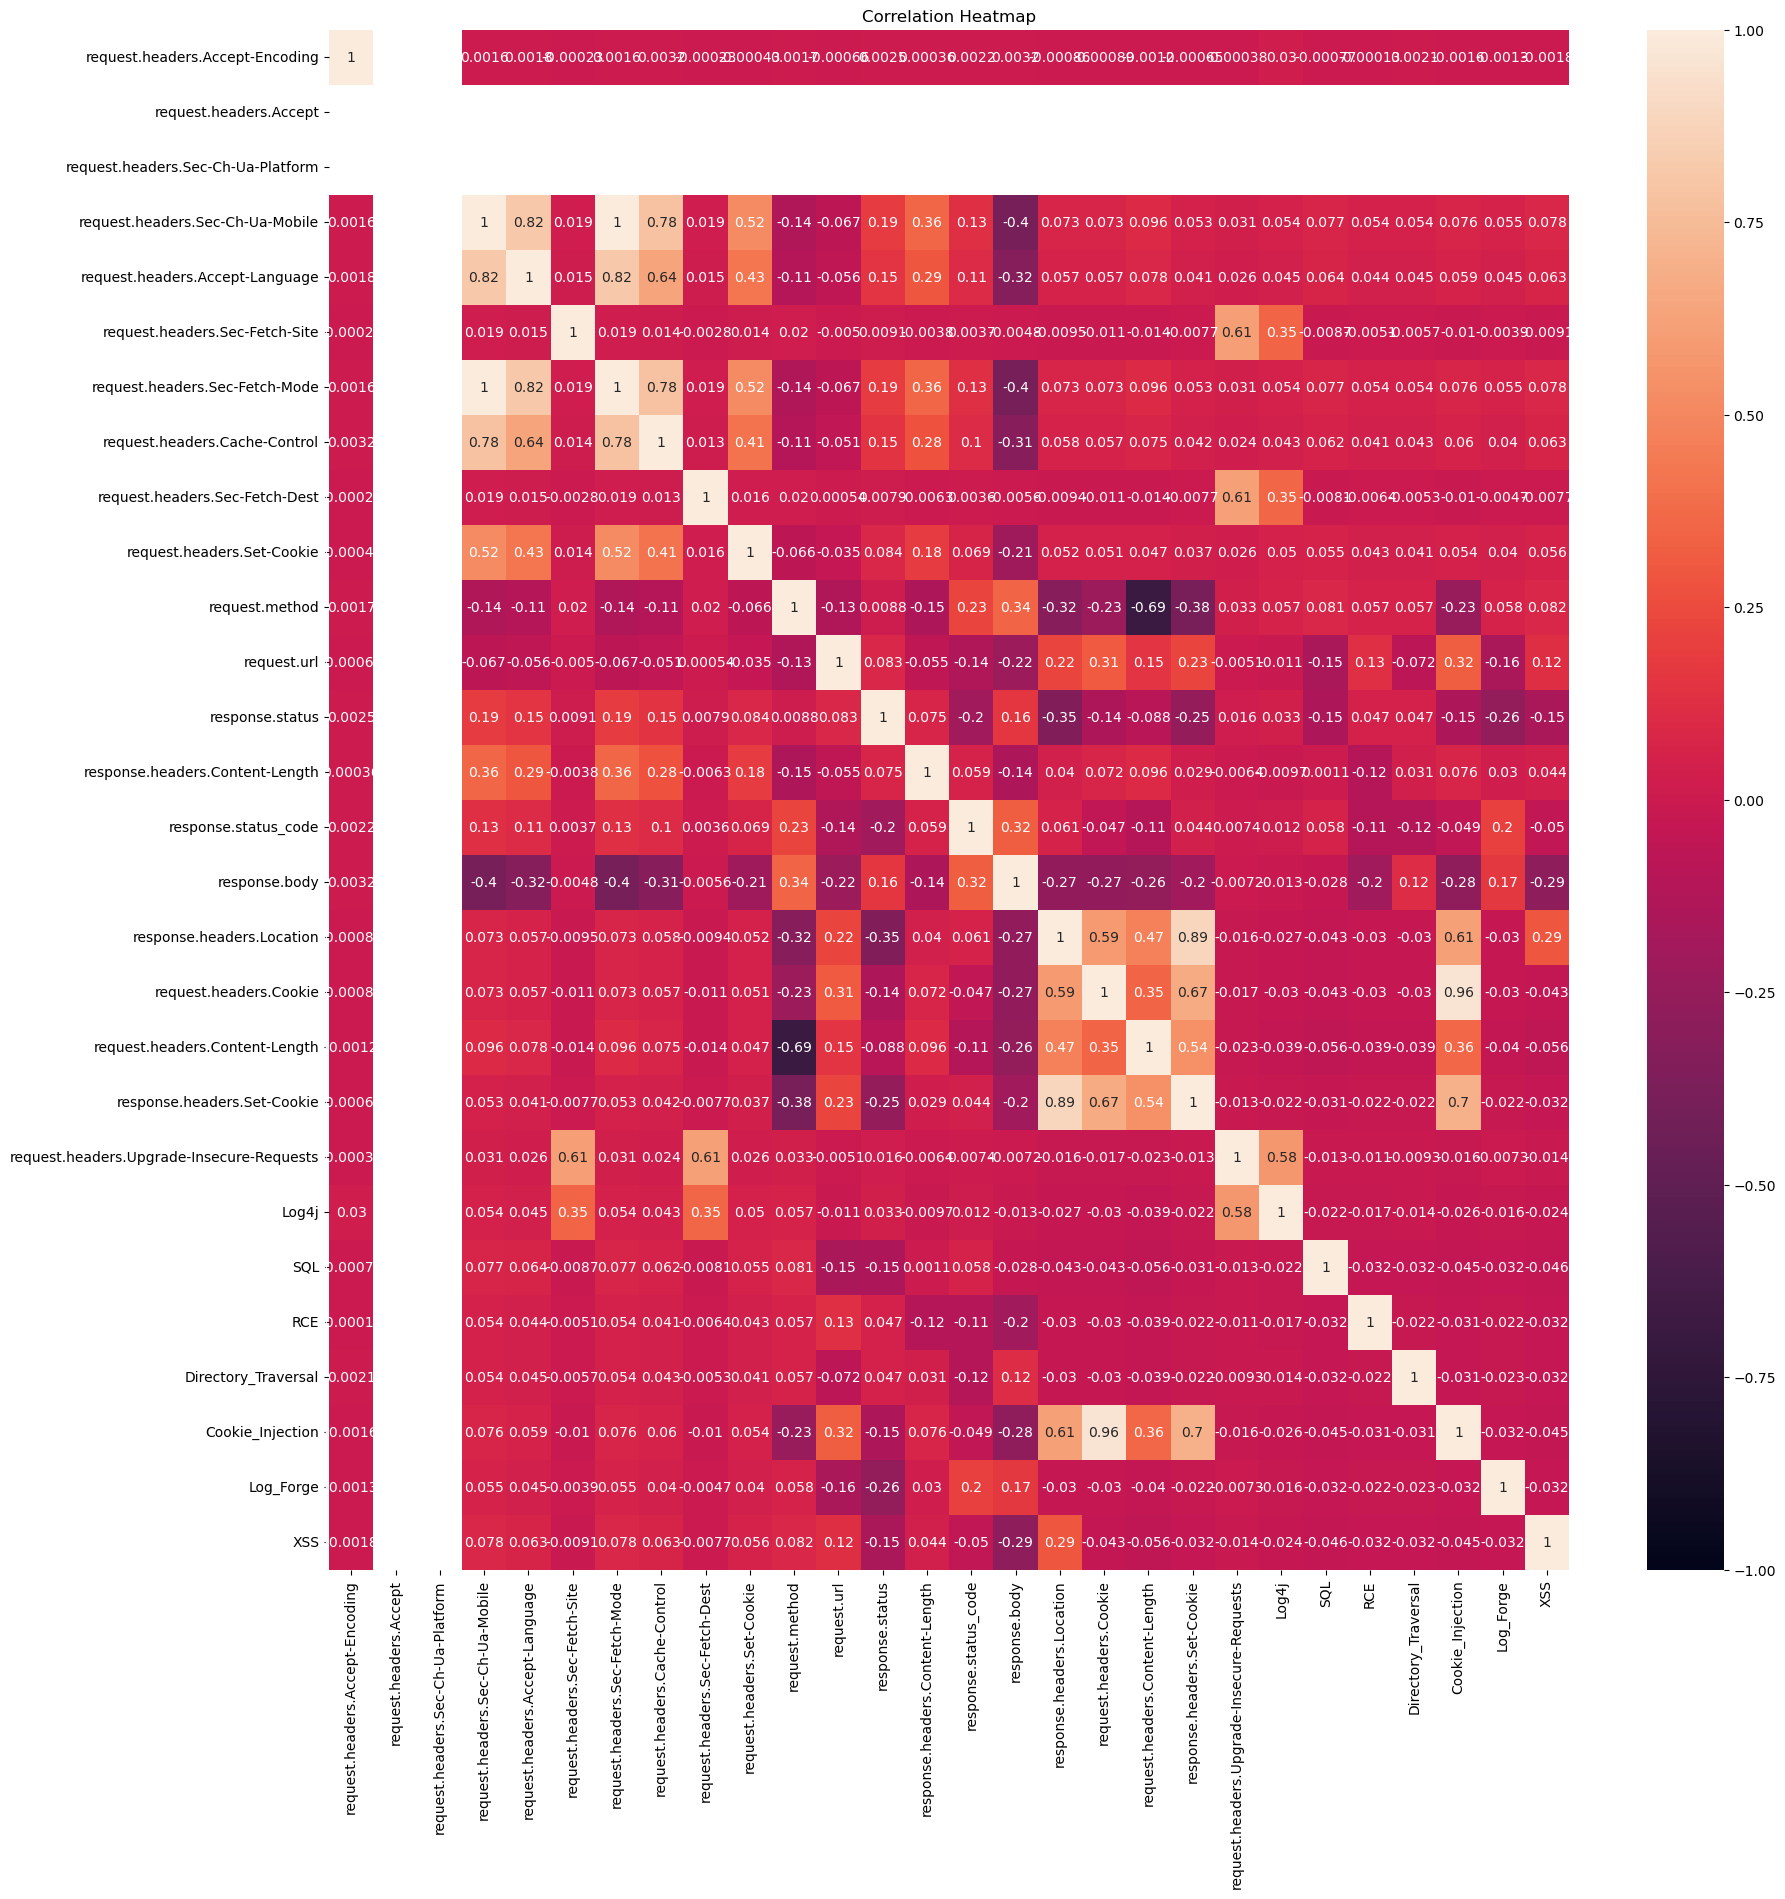

In [19]:
# Increase the size of the heatmap.
plt.figure(figsize=(20, 20))
# Store heatmap object in a variable to easily access it when you want to include more features (such as title).
# Set the range of values to be displayed on the colormap from -1 to 1, and set the annotation to True to display the correlation values on the heatmap.
heatmap = sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True)
# Give a title to the heatmap. Pad defines the distance of the title from the top of the heatmap.
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12});

In [20]:
features_list = df.columns.to_list()
features_list.remove('attack_type')

print(features_list)

['request.headers.Accept-Encoding', 'request.headers.Accept', 'request.headers.Sec-Ch-Ua-Platform', 'request.headers.Sec-Ch-Ua-Mobile', 'request.headers.Accept-Language', 'request.headers.Sec-Fetch-Site', 'request.headers.Sec-Fetch-Mode', 'request.headers.Cache-Control', 'request.headers.Sec-Fetch-Dest', 'request.headers.Set-Cookie', 'request.method', 'request.url', 'response.status', 'response.headers.Content-Length', 'response.status_code', 'response.body', 'response.headers.Location', 'request.headers.Cookie', 'request.headers.Content-Length', 'response.headers.Set-Cookie', 'request.headers.Upgrade-Insecure-Requests', 'Log4j', 'SQL', 'RCE', 'Directory_Traversal', 'Cookie_Injection', 'Log_Forge', 'XSS']


In [21]:
# Data train and test split preparations. Here we will insert our feature list and label list.
# Afterwards the data will be trained and fitted on the amazing XGBoost model
# X_Train and y_Train will be used for training
# X_test and y_test.T will be used for over fitting checking and overall score testing

# We convert the feature list to a numpy array, this is required for the model fitting
X = df[features_list].to_numpy()

# This column is the desired prediction we will train our model on
y = np.stack(df[test_type])

# We split the dataset to train and test according to the required ration
# Do not change the test_size -> you can change anything else
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1765, random_state=42, stratify=y)

# We print the resulted datasets and count the difference 
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
counter = Counter(y)
counter

(150508, 28) (150508,)
(32259, 28) (32259,)


Counter({'Benign': 143297,
         'LOG4J': 3756,
         'XSS': 8062,
         'Cookie Injection': 7725,
         'SQL Injection': 7919,
         'RCE': 3957,
         'Directory Traversal': 3985,
         'Log Forging': 4066})

In [22]:
# Convert the labels to integers
AttackDict = {'Benign': 0, 'Cookie Injection': 1, 'Directory Traversal': 2, 'LOG4J': 3, 'Log Forging': 4, 'RCE': 5, 'SQL Injection': 6, 'XSS': 7}
y_train = [AttackDict[y] for y in y_train]
y_test = [AttackDict[y] for y in y_test]

In [23]:
# define the parameters
params = {
    'booster': 'gbtree',
    'learning_rate': 0.55,
    'max_depth': 2,
    'n_estimators': 60, 
    'reg_lambda': 1
}

# create the XGBoost model
model = xgb.XGBClassifier(**params)
model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.55, max_bin=256,
              max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
              max_depth=2, max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=60, n_jobs=0,
              num_parallel_tree=1, objective='multi:softprob', predictor='auto', ...)

In [24]:
# evaluate the model on the testing data
accuracy = model.score(X_test, y_test)
print(f'Model accuracy: {accuracy:.2f}')

Model accuracy: 1.00


              precision    recall  f1-score   support

           0    1.00000   1.00000   1.00000     25292
           1    1.00000   1.00000   1.00000      1364
           2    1.00000   1.00000   1.00000       703
           3    1.00000   1.00000   1.00000       663
           4    1.00000   1.00000   1.00000       718
           5    1.00000   1.00000   1.00000       698
           6    1.00000   1.00000   1.00000      1398
           7    1.00000   1.00000   1.00000      1423

    accuracy                        1.00000     32259
   macro avg    1.00000   1.00000   1.00000     32259
weighted avg    1.00000   1.00000   1.00000     32259



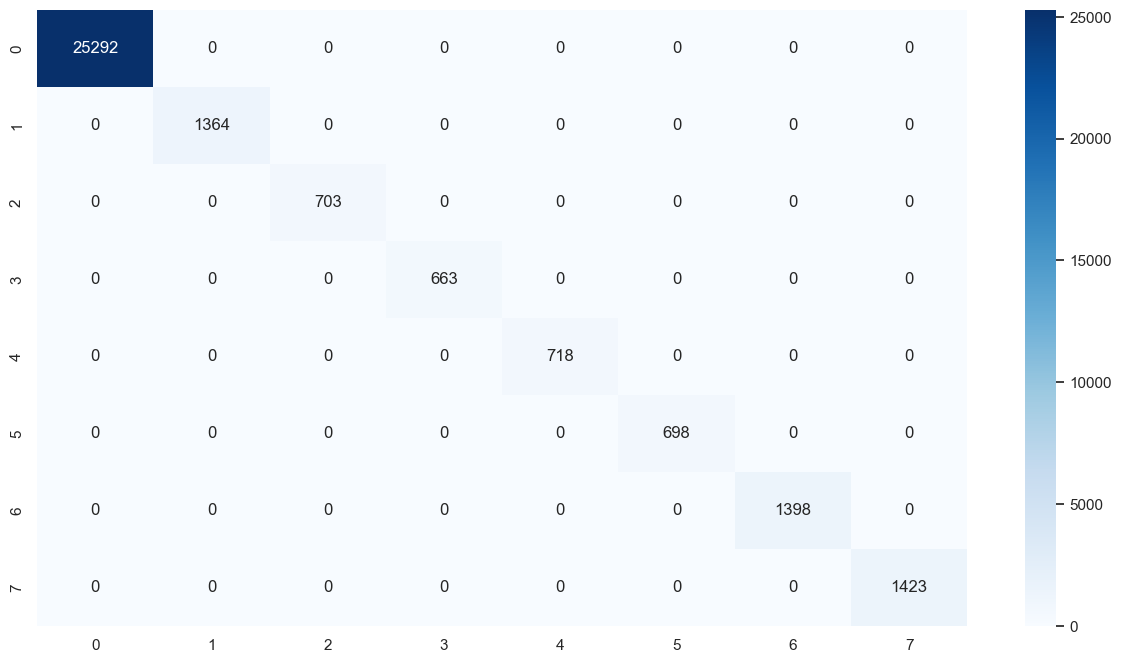

In [25]:
# We print our results
sns.set(rc={'figure.figsize':(15,8)})
predictions = model.predict(X_test)
true_labels = y_test
model_matrix = confusion_matrix(true_labels, predictions)
model_report = classification_report(true_labels, predictions, digits=5)
heatmap = sns.heatmap(model_matrix, annot=True, cmap='Blues', fmt='g', 
                      xticklabels=np.unique(true_labels), 
                      yticklabels=np.unique(true_labels)) 

# The heatmap is cool but this is the most important result
print(model_report)

In [26]:
# Now it's your turn, use the model you have just created :)

# Read the valuation json, preprocess it and run your model 
with open(f'datasets/dataset_{str(dataset_number)}_val.json') as file:
    raw_ds = json.load(file)
test_df = pd.json_normalize(raw_ds, max_level=2)

In [27]:
for column in test_df.columns[test_df.isna().any()].tolist():
    # df.drop(column, axis=1, inplace=True)
    test_df[column] = test_df[column].fillna('None')
# Preprocess the validation dataset, remember that here you don't have the labels
test_df.head()


,request.headers.Host,request.headers.User-Agent,request.headers.Accept-Encoding,request.headers.Accept,request.headers.Connection,request.headers.Sec-Ch-Ua-Mobile,request.headers.Accept-Language,request.headers.Sec-Fetch-Site,request.headers.Sec-Fetch-Mode,request.headers.Cache-Control,request.headers.Sec-Fetch-User,request.headers.Sec-Fetch-Dest,request.headers.Set-Cookie,request.headers.Date,request.method,request.url,request.body,response.status,response.headers.Content-Type,response.headers.Content-Length,response.status_code,response.body,request.headers.Sec-Ch-Ua-Platform,request.headers.Content-Length,response.headers.Location,request.headers.Cookie,response.headers.Set-Cookie,request.headers.Upgrade-Insecure-Requests
0,127.0.0.1:5000,Mozilla/5.0 (Windows NT 5.1) AppleWebKit/537.3...,"gzip, deflate, br",*/*,keep-alive,?1,"en-US,en;q=0.5",none,websocket,max-age=0,?1,document,['ck=WP4apE8KHQSTZBX9kx7cvWTrThwDMKlybR7wL3EwN...,"Sun, 18 Dec 2022 01:22:25 GMT",GET,http://127.0.0.1:5000/forum,,200 OK,text/html; charset=utf-8,52580,200,text/html; charset=utf-8,None,None,None,None,None,None
1,127.0.0.1:5000,Mozilla/5.0 (Windows NT 4.0; WOW64) AppleWebKi...,"gzip, deflate, br",*/*,keep-alive,?1,"en-US,en;q=0.9,he;q=0.8",none,websocket,max-age=0,?1,document,['cid=Cziiu8ULTeufPE1g40GeQaOFYcIZVLiB0LjWDqoO...,"Sun, 18 Dec 2022 01:49:44 GMT",POST,http://127.0.0.1:5000/forgot-password,okS0GXYRSP9ABddqnOgM,200 OK,application/json,141,200,"{""message"": ""Reset link was sent to this email...","""Windows""",20,None,None,None,None
2,127.0.0.1:5000,Mozilla/5.0 (Windows NT 6.1; Win64; x64; rv:25...,"x-gzip, x-deflate, gzip, deflate",*/*,keep-alive,?1,de-CH,none,same-origin,no-store,?1,document,['ck=7OXWoFbHDNCZlNlDOajc02zVRzo_esFhpAt_JnhZj...,"Sun, 18 Dec 2022 01:21:28 GMT",POST,http://127.0.0.1:5000/categories/check/all?fil...,ShmMK0HcQijBloDhmeO6,200 OK,application/json,871,200,"[{""category_id"": ""1"", ""category_name"": ""Bevera...","""Windows""",20,None,None,None,None
3,127.0.0.1:5000,Mozilla/5.0 (Windows NT 5.1) AppleWebKit/537.3...,"x-gzip, x-deflate, gzip, deflate",*/*,keep-alive,?1,"en-US,en;q=0.9,he;q=0.8",none,websocket,max-age=0,?1,document,['cid=WlkCQThBcDH7JqJsUSX661fQKcW_3Drc65yKTqbm...,"Sun, 18 Dec 2022 01:39:51 GMT",GET,http://127.0.0.1:5000/?id=9263979.549875157&re...,,200 OK,text/html; charset=utf-8,34,200,text/html; charset=utf-8,"""Windows""",None,None,None,None,None
4,127.0.0.1:5000,Mozilla/5.0 (Windows NT 6.1; Win64; x64; rv:25...,"gzip, deflate, br",*/*,keep-alive,?0,"en-US,en;q=0.5",none,websocket,no-store,?1,document,['ttauth=mMuAu2YMwZNIDKhH1Pcifat1GJ56PBUhi4goh...,"Sun, 18 Dec 2022 01:24:29 GMT",GET,http://127.0.0.1:5000/about/greet?resource=PWw...,,200 OK,text/html; charset=utf-8,93,200,text/html; charset=utf-8,"""Windows""",None,None,None,None,None


In [28]:
# Preprocess the validation dataset, remember that here you don't have the labels

test_df['Log4j'] = test_df.apply(lambda row: check_for_Log4j(row), axis=1)

test_df['SQL'] = test_df.apply(lambda row: check_for_SQL_injection(row), axis=1)

test_df['RCE'] = test_df.apply(lambda row: check_for_RCE(row), axis=1)

test_df['Cookie_Injection'] = test_df.apply(lambda row: check_for_Cookie_injection(row), axis=1)

test_df['Directory_Traversal'] = test_df.apply(lambda row: check_for_Directory_Traversal(row), axis=1)

test_df['Log_Forge'] = test_df.apply(lambda row: check_for_Log_Forge(row), axis=1)

test_df['XSS'] = test_df.apply(lambda row: check_for_XSS(row), axis=1)

test_df = vectorize_df(test_df)
test_df.head()

,request.headers.Accept-Encoding,request.headers.Accept,request.headers.Sec-Ch-Ua-Mobile,request.headers.Accept-Language,request.headers.Sec-Fetch-Site,request.headers.Sec-Fetch-Mode,request.headers.Cache-Control,request.headers.Sec-Fetch-Dest,request.headers.Set-Cookie,request.method,request.url,response.status,response.headers.Content-Length,response.status_code,response.body,request.headers.Sec-Ch-Ua-Platform,request.headers.Content-Length,response.headers.Location,request.headers.Cookie,response.headers.Set-Cookie,request.headers.Upgrade-Insecure-Requests,Log4j,SQL,RCE,Cookie_Injection,Directory_Traversal,Log_Forge,XSS
0,0.0,0.0,0.0,-0.447214,-1.0,0.0,0.0,-1.0,-0.721995,0.0,0.707107,0.707107,-1.0,200,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0,0,0,0,0,0,1
1,0.0,0.0,0.0,-0.316228,-1.0,0.0,0.0,-1.0,-0.280976,-1.0,0.577350,0.707107,1.0,200,-0.471405,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0,0,0,0,0,0,0
2,0.0,0.0,0.0,0.000000,-1.0,0.0,0.0,-1.0,-0.436436,-1.0,0.408248,0.707107,-1.0,200,-0.255551,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0,0,0,0,0,0,0
3,0.0,0.0,0.0,-0.316228,-1.0,0.0,0.0,-1.0,-0.345547,0.0,0.408248,0.707107,0.0,200,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0,0,0,0,0,0,0
4,0.0,0.0,0.0,-0.447214,-1.0,0.0,0.0,-1.0,-0.363636,0.0,0.316228,0.707107,-1.0,200,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0,0,0,0,0,0,0


In [29]:
# Predict with your model
X = test_df[features_list].to_numpy()
predictions = model.predict(X)

In [30]:
enc = LabelEncoder()
np.savetxt(f'results/dataset_{str(dataset_number)}_{test_type}_result.txt', enc.fit_transform(predictions), fmt='%2d')